# Deep Reinforcement Learning - Assignment 3
## Training and Comparing Meta-Learning and Transfer-Learning using an Actor-Critic agent

This notebook implements, trains, and evaluates Policy Gradient agents.

### Assignment Structure:
- **Section 1**: One step Actor-Critic for Different Tasks
- **Section 2**: Fine-Tuning a Trained Model for Different Tasks:
    - CartPole-v1
    - Acrobot-v1
    - MountainCarContinuous-v0 (discretized via adapters)   
- **Section 3**: Transfer-Learning
- **Section 4**: Comparison and Analysis

---

In [3]:
!git clone https://github.com/shaharoded/TransferLearning.git
%cd TransferLearning

Cloning into 'TransferLearning'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 13 (delta 0), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (13/13), 201.54 KiB | 10.08 MiB/s, done.
/content/TransferLearning


In [1]:
# Setup: Add project root to Python path
import os
import sys
from __future__ import annotations

# Get the notebook's directory
notebook_dir = os.path.abspath('')
project_root = notebook_dir  # Since notebook is in project root

# Add to path if not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root: {project_root}")

Project root: /content


In [5]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib

# PyTorch
import torch

# Gymnasium
import gymnasium as gym

# Disable PyTorch 2.0+ compilation features that might cause issues
torch._dynamo.config.suppress_errors = True
import torch._dynamo
torch._dynamo.disable()

# Force complete module reload
modules_to_remove = [key for key in list(sys.modules.keys()) 
                    if 'agent' in key.lower() or 'src' in key or 'utils' in key or 'ffnn' in key]
for module in modules_to_remove:
    del sys.modules[module]

# Import custom modules
import src.adapters
import src.ffnn
import src.agent
import src.train
import src.training_utils

from src.adapters import get_default_env_specs
from src.agent import AgentConfig, ActorCriticAgent
from src.train import train_actor_critic
from src.training_utils import plot_training_curves_grid, plot_diagnostics_grid, summarize_run

# Reload to get latest changes (run this cell again after editing source files)
importlib.reload(src.adapters)
importlib.reload(src.ffnn)
importlib.reload(src.agent)
importlib.reload(src.train)
importlib.reload(src.training_utils)

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- SEED SETTING ---
SEED = 42
def set_seeds(seed=SEED, env=None):
    """Set seeds for reproducibility across numpy, random, torch, and gym."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
    if env is not None:
        env.action_space.seed(seed)
        env.reset(seed=seed)
        print(f"✓ Environment seeded with {seed}")

set_seeds()
print(f"✓ Global seeds set to {SEED}")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ Modules reloaded successfully")

✓ Global seeds set to 42
✓ PyTorch version: 2.9.0+cu126
✓ Modules reloaded successfully


In [6]:
STATE_DIM = 6
ACTION_DIM = 5

# Moving average window for convergence
MA_WINDOW = 100

specs = get_default_env_specs(state_dim=STATE_DIM, action_dim=ACTION_DIM)

# Quick sanity check: masks and dims
for name, spec in specs.items():
    print(name, "obs_dim=", spec.obs_dim, "state_dim=", spec.state_dim, "action_dim=", spec.action_dim, "valid_actions=", spec.valid_action_indices)

cartpole obs_dim= 4 state_dim= 6 action_dim= 5 valid_actions= (0, 1)
acrobot obs_dim= 6 state_dim= 6 action_dim= 5 valid_actions= (0, 1, 2)
mountaincar obs_dim= 2 state_dim= 6 action_dim= 5 valid_actions= (0, 1, 2, 3, 4)


## Part 1: Training Individual Networks 

In this part, using the same architectures (+ adapters), we'll train seperate networks per task

In [7]:
# Shared Agent architecture
# Agent learning config (If needed: override per env)
BASE_AGENT_CFG = AgentConfig(
    gamma=0.99,
    hidden_sizes=[128],
    actor_lr=5e-4,
    critic_lr=1e-3,
    entropy_coef=0.01,
    grad_clip_norm=None,
)

MOUNTAINCAR_CFG = AgentConfig(
    gamma=0.99,
    hidden_sizes=[128],
    actor_lr=3e-4,      # slightly smaller actor lr helps stability here
    critic_lr=1e-3,
    entropy_coef=0.08,  # more exploration
    grad_clip_norm=None,
)

# Task configs (keep here, not in train.py)
TASKS = {
    "cartpole": {
        "gym_id": "CartPole-v1",
        "target_reward": 475,
        "max_episodes": 2000,
        "max_steps": 500,
        "agent_cfg": BASE_AGENT_CFG,
    },
    "acrobot": {
        "gym_id": "Acrobot-v1",
        # rewards are negative; set target accordingly to your course spec/tuning
        "target_reward": -100,
        "max_episodes": 4000,
        "max_steps": 500,
        "agent_cfg": BASE_AGENT_CFG,
    },
    "mountaincar": {
        "gym_id": "MountainCarContinuous-v0",
        "target_reward": 90,
        "max_episodes": 5000,
        "max_steps": 1000,
        "agent_cfg": MOUNTAINCAR_CFG,
    }
}

In [8]:
histories = {}

for env_name, cfg in TASKS.items():
    if env_name != 'mountaincar':
        continue  # Skip other envs for now
    print("\n" + "="*80)
    print(f"Training {env_name} ({cfg['gym_id']})")
    print("="*80)

    # 1) Create env
    env = gym.make(cfg["gym_id"])
    env.reset(seed=SEED)
    env.action_space.seed(SEED)

    # 2) Create agent
    agent = ActorCriticAgent(
        env_spec=specs[env_name],
        config=cfg["agent_cfg"],
        seed=SEED,
    )

    # 3) Train (train.py is a pure runner)
    histories[env_name] = train_actor_critic(
        env=env,
        agent=agent,
        max_episodes=cfg["max_episodes"],
        max_steps_per_episode=cfg["max_steps"],
        ma_window=MA_WINDOW,
        target_reward=cfg["target_reward"],
        verbose=True,
        print_every=50,
        reset_seed_base=SEED,  # optional: stable but varying resets per episode
    )

    env.close()

    print("Summary:", summarize_run(histories[env_name]))


Training mountaincar (MountainCarContinuous-v0)
[mountaincar] ep=   1 R=  -42.10 MA(100)=  -42.10 len= 999


KeyboardInterrupt: 

In [34]:
rewards = histories["mountaincar"]["rewards"]
lens = histories["mountaincar"]["episode_lengths"]

last = 100
success_rate = sum(l < 999 for l in lens[-last:]) / min(last, len(lens))
print("Success rate last 100:", success_rate)

print("Best len:", min(lens))
print("Best reward:", max(rewards))

KeyError: 'mountaincar'

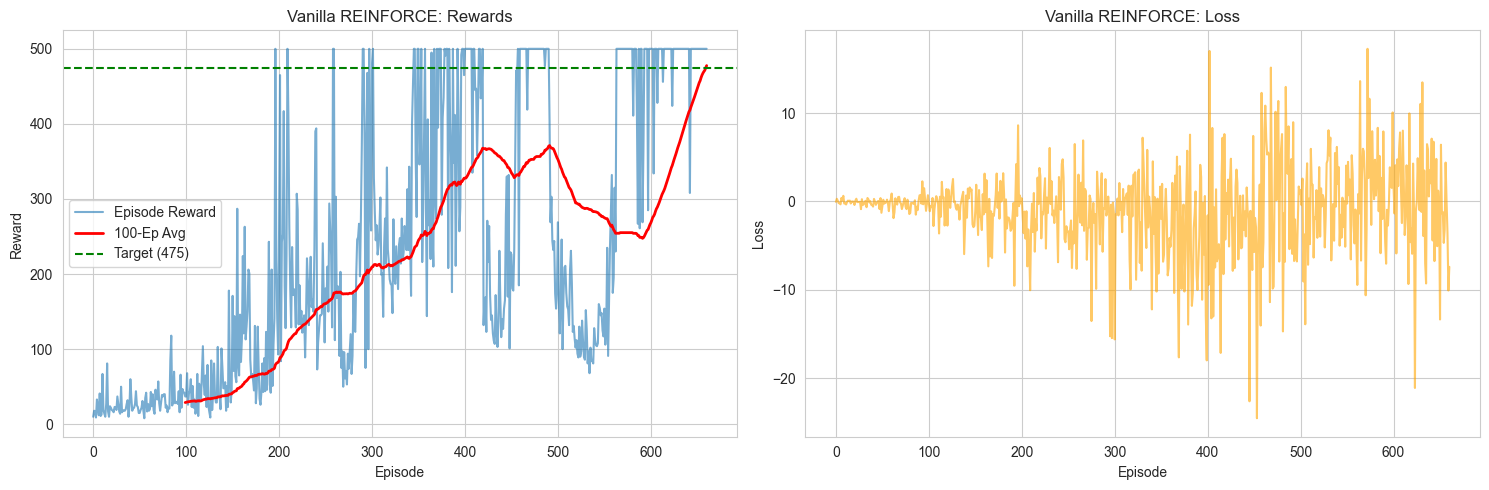

✓ Saved reinforce to models/


In [ ]:
# Analyze
order = ["cartpole", "acrobot", "mountaincar"]

thresholds = {k: TASKS[k]["target_reward"] for k in order}
titles = {k: TASKS[k]["gym_id"] for k in order}

plot_training_curves_grid(
    histories,
    order=order,
    titles=titles,
    thresholds=thresholds,
    grid_shape=(1, 3),
    figsize=(18, 4),
)

plot_diagnostics_grid(
    histories,
    order=order,
    grid_shape=(1, 3),
    figsize=(18, 4),
)